## Loading an HCA matrix into scanpy

This vignette illustrates requesting an expression matrix from the HCA matrix service and loading it into scanpy.


First, install and import some dependencies:

In [ ]:
import sys
!{sys.executable} -m pip install loompy pandas requests scanpy
import json, os, requests, scanpy.api as sc, shutil, time, zipfile

Now, we're going to make some requests to describe what fields and values we can filter on when we're selecting our matrix.

In [3]:
MATRIX_URL = "https://matrix.dev.data.humancellatlas.org/v1"
resp = requests.get(MATRIX_URL + "/filters")
print(resp.text)

[
  "cell_suspension.provenance.document_id",
  "genes_detected",
  "specimen_from_organism.provenance.document_id",
  "specimen_from_organism.genus_species.ontology",
  "specimen_from_organism.genus_species.ontology_label",
  "donor_organism.human_specific.ethnicity.ontology",
  "donor_organism.human_specific.ethnicity.ontology_label",
  "donor_organism.diseases.ontology",
  "donor_organism.diseases.ontology_label",
  "donor_organism.development_stage.ontology",
  "donor_organism.development_stage.ontology_label",
  "derived_organ_ontology",
  "derived_organ_label",
  "derived_organ_part_ontology",
  "derived_organ_part_label",
  "library_preparation_protocol.provenance.document_id",
  "library_preparation_protocol.input_nucleic_acid_molecule.ontology",
  "library_preparation_protocol.input_nucleic_acid_molecule.ontology_label",
  "library_preparation_protocol.library_construction_method.ontology",
  "library_preparation_protocol.library_construction_method.ontology_label",
  "library

That's the list of metadata fields we can filter on when requesting the matrix. We can describe any of them with further API calls:

In [4]:
resp = requests.get(MATRIX_URL + "/filters/project.project_core.project_title")
print(resp.text)

{
  "cell_counts": {
    "": 4394,
    "Assessing the relevance of organoids to model inter-individual variation": 40955,
    "Census of Immune Cells": 794365,
    "Ischaemic sensitivity of human tissue by single cell RNA seq": 40189,
    "Reconstructing the human first trimester fetal-maternal interface using single cell transcriptomics": 7598,
    "Single cell transcriptome analysis of human pancreas reveals transcriptional signatures of aging and somatic mutation patterns.": 2544,
    "Single-cell RNA-seq analysis  throughout a 125-day differentiation protocol that converted H1 human embryonic stem cells to a variety of ventrally-derived cell types.": 1733
  },
  "field_description": "Just what it sounds like.",
  "field_name": "project.project_core.project_title",
  "field_type": "categorical"
}



In [5]:
resp = requests.get(MATRIX_URL + "/filters/genes_detected")
print(resp.text)

{
  "field_description": "Just what it sounds like.",
  "field_name": "genes_detected",
  "field_type": "numeric",
  "maximum": 13108,
  "minimum": 6
}



For categorical data, we see the number of cells associated with each category. For numeric, we see the range of value. If we want to request a matrix based on these metadat values, we can add them to the `filter` in the body of a POST request to the matrix service:

In [6]:
resp = requests.post(
    MATRIX_URL + "/matrix",
    json={"filter":
          {"op": "and",
           "value": [
               {"op": "=",
                "value": "Single cell transcriptome analysis of human pancreas",
                "field": "project.project_core.project_short_name"},
               {"op": ">=",
                "value": 3000,
                "field": "genes_detected"}
           ]
          }})
print(resp.text)

{
  "eta": "",
  "matrix_url": "",
  "message": "Job started.",
  "request_id": "f4045eda-97b3-4f97-9d0d-041d1746e0d0",
  "status": "In Progress"
}



That call responds right away and tells us that the matrix is being prepared. We can use the `request_id` to wait until the matrix is done.

In [7]:
while True:
    status_resp = requests.get(
        MATRIX_URL + "/matrix/" + resp.json()["request_id"])
    if status_resp.json()["status"] == "Complete":
        break
    print("Waiting...")
    time.sleep(30)
print(status_resp.text)

Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
{
  "eta": "",
  "matrix_url": "https://s3.amazonaws.com/dcp-matrix-service-query-results-dev/f4045eda-97b3-4f97-9d0d-041d1746e0d0.loom.zip",
  "message": "Request f4045eda-97b3-4f97-9d0d-041d1746e0d0 has successfully completed. The resultant expression matrix is available for download at https://s3.amazonaws.com/dcp-matrix-service-query-results-dev/f4045eda-97b3-4f97-9d0d-041d1746e0d0.loom.zip",
  "request_id": "f4045eda-97b3-4f97-9d0d-041d1746e0d0",
  "status": "Complete"
}



Now, that the matrix is ready, we can download it. The file we download is a zip archive that contains a readme and a loom-formatted matrix. Loom is the default matrix format, but others can be specified in the matrix request.

In [8]:
matrix_response = requests.get(status_resp.json()["matrix_url"], stream=True)
matrix_zip_filename = os.path.basename(status_resp.json()["matrix_url"])
with open(matrix_zip_filename, 'wb') as matrix_zip_file:
    shutil.copyfileobj(matrix_response.raw, matrix_zip_file)
zipfile.ZipFile(matrix_zip_filename).extractall()

In [ ]:
print(open("loom_readme.md").read())

## HCA Matrix Service Loom Output

The loom-formatted output from the matrix service is a zip archive that contains two files:

| Filename                         | Description                   |
|--------------------------------- |-------------------------------|
| loom_readme.txt                  | This readme                   |
| <file_name>.loom                 | Loom file with requested data |

The Loom format is documented more fully, along with code samples,
[here](https://linnarssonlab.org/loompy/index.html).

Per Loom
[conventions](https://linnarssonlab.org/loompy/conventions/index.html), columns
in the loom-formatted expression matrix represent cells, and rows represent
genes. The column and row attributes follow Loom conventions where applicable
as well: `CellID` uniquely identifies a cell, `Gene` is a gene name, and
`Accession` is an ensembl gene id.

Descriptions of the remaining metadata fields are available at the 
[HCA Data Browser](https://prod.data.humancellatlas.org/metadata).

And finally, we can use the `read_loom` method from scanpy, to load the matrix and peforms some analyses.

In [10]:
matrix_loom_filename = matrix_zip_filename.rstrip(".zip")
adata = sc.read_loom(matrix_loom_filename, var_names="Accession")

In [11]:
adata.shape

(2146, 63925)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'analysis_protocol.protocol_core.protocol_id' as categorical
... storing 'analysis_working_group_approval_status' as categorical
... storing 'derived_organ_label' as categorical
... storing 'derived_organ_ontology' as categorical
... storing 'derived_organ_part_label' as categorical
... storing 'derived_organ_part_ontology' as categorical
... storing 'donor_organism.development_stage.ontology' as categorical
... storing 'donor_organism.development_stage.ontology_label' as categorical
... storing 'donor_organism.diseases.ontology' as categorical
... storing 'donor_organism.diseases.ontology_label' as categorical
... storing 'donor_organism.human_specific.ethnicity.ontology' as categorical
... storing 'donor_organism.human_specific.ethnicity.ontology_label' as categorical
... storing 'library_preparation_protocol.end_bias' as categorical
... storing 'library_preparation_protocol.input_nucleic_acid_molecule.ontology' as categorical
... storing 'library_preparation_protocol.inp

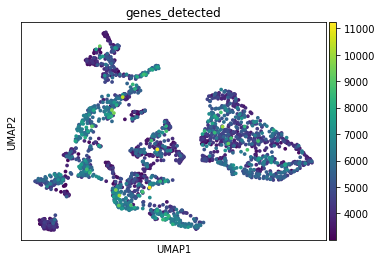

In [12]:
sc.pp.normalize_per_cell(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="genes_detected")